- ## EDA:

In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt

In [2]:
data_path=os.getcwd()
print('No of trainning Images',len(os.listdir(os.path.join(data_path,'stage_2_train_images'))))
print('No of testing Images',len(os.listdir(os.path.join(data_path,'stage_2_test_images'))))

No of trainning Images 26684
No of testing Images 3000


In [3]:
def wrangle(file_path):
  df=pd.read_csv(file_path)
  df = df.drop_duplicates(subset=['patientId'])
  df['Target']=pd.to_numeric(df['Target'])
  return df[['Target','patientId']]

In [4]:
df=wrangle('stage_2_train_labels.csv')

df.head()

,Target,patientId
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,0,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,0,00322d4d-1c29-4943-afc9-b6754be640eb
3,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4,1,00436515-870c-4b36-a041-de91049b9ab4


In [5]:
print('No. Duplicated',df.duplicated().sum())
print('No. Samples',len(df))

No. Duplicated 0
No. Samples 26684


In [6]:
sample=df.iloc[1]
sample

Target                                          0
patientId    00313ee0-9eaa-42f4-b0ab-c148ed3241cd
Name: 1, dtype: object

In [7]:
data_path

'c:\\Users\\ahmed\\Downloads\\Projects\\pp\\pneumonia'

Image shape:  (1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

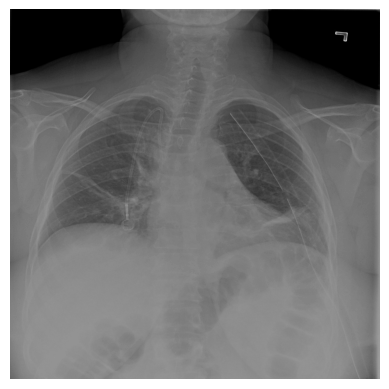

In [8]:
image=pydicom.dcmread(f"{data_path}/stage_2_train_images/{sample['patientId']}.dcm").pixel_array
print('Image shape: ',image.shape)
plt.imshow(image,cmap='gray')
plt.axis('off')

In [9]:
image.shape

(1024, 1024)

(-0.5, 149.5, 149.5, -0.5)

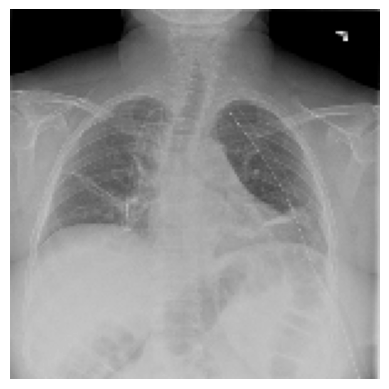

In [10]:
import cv2

resized=cv2.resize(image,(150,150))

plt.imshow(resized,cmap='gray')
plt.axis('off')

In [11]:
df['Target'].value_counts()

Target
0    20672
1     6012
Name: count, dtype: int64

<Axes: xlabel='Target', ylabel='count'>

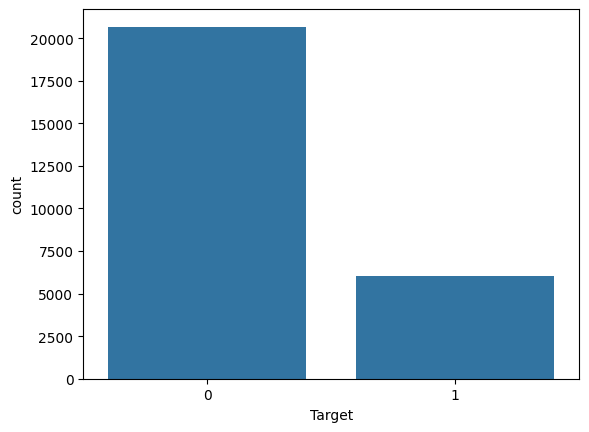

In [12]:
import seaborn as sns

sns.countplot(data=df,x='Target')

- ### Splite Data:

In [13]:
from sklearn.model_selection import train_test_split
x=df['patientId']
y=df['Target']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,stratify=y,test_size=.1,random_state=42)
xtrain,xval,ytrain,yval=train_test_split(xtrain,ytrain,stratify=ytrain,test_size=.1,random_state=42)

In [14]:
xtrain_df = pd.DataFrame(xtrain, columns=['patientId'])
ytrain_df = pd.DataFrame(ytrain, columns=['Target'])
df_train = pd.concat([xtrain_df, ytrain_df], axis=1)
df_train.reset_index(drop=True, inplace=True)

In [15]:
xtest_df = pd.DataFrame(xtest, columns=['patientId'])
ytest_df = pd.DataFrame(ytest, columns=['Target'])
df_test = pd.concat([xtest_df, ytest_df], axis=1)
df_test.reset_index(drop=True, inplace=True)

In [16]:
xval_df = pd.DataFrame(xval, columns=['patientId'])
yval_df = pd.DataFrame(yval, columns=['Target'])
df_val = pd.concat([xval_df, yval_df], axis=1)
df_val.reset_index(drop=True, inplace=True)

In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes=np.unique(ytrain),
                                                  y= np.array(ytrain))

class_weight_dict=dict(zip(np.unique(ytrain),class_weights))

print(class_weight_dict)

{0: 0.6454339126799259, 1: 2.2189938398357287}


- ## DataGenrator



In [18]:
from keras.utils import Sequence
import albumentations as A


class DCMGenerator(Sequence):
    def __init__(self, csv, batch_size, image_shape, images_path,transformations,augmentation=False, shuffle=True):
        self.df = csv
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.images_dir = images_path
        self.shuffle = shuffle
        self.augmentation = augmentation

        # Define augmentations
        self.augmentor = transformations

        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def load_dcm(self, file_name):
        image = pydicom.dcmread(file_name).pixel_array
        if self.image_shape is not None:
            image = cv2.resize(image, self.image_shape)
        image=np.expand_dims(image,axis=-1)
        image=np.concatenate([image,image,image],axis=-1)
        #image=preprocess_input(image)
        return image/255.

    def apply_augmentation(self, image):
        augmented = self.augmentor(image=image)
        return augmented['image']

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch = self.df.iloc[start:end]

        # Load and augment images
        images = [self.load_dcm(os.path.join(self.images_dir, file) + '.dcm') for file in batch['patientId']]
        if self.augmentation:
            images = [self.apply_augmentation(image) for image in images]

        images = np.array(images)
        y = np.array(batch['Target'], dtype=float)

        return images, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [19]:
image_dim=224

transforms=A.Compose([
    A.RandomCrop(width=image_dim, height=image_dim),
    A.HorizontalFlip(p=0.4),
    #A.ShiftScaleRotate(shift_limit=0.1, rotate_limit=10, p=0.3),
    A.Rotate(limit=10,p=.4),
    #A.RandomBrightnessContrast(p=.2),
    ])

In [20]:
path=f"{data_path}/stage_2_train_images"
batch_size=8
train_gen=DCMGenerator(df_train,batch_size=batch_size,image_shape=(image_dim,image_dim),images_path=path,transformations=transforms,augmentation=True)
test_gen=DCMGenerator(df_test,batch_size=batch_size,image_shape=(image_dim,image_dim),images_path=path,transformations=None)
val_gen=DCMGenerator(df_val,batch_size=batch_size,image_shape=(image_dim,image_dim),images_path=path,transformations=None)

In [21]:
for batch in train_gen:
  images,labels =batch
  break

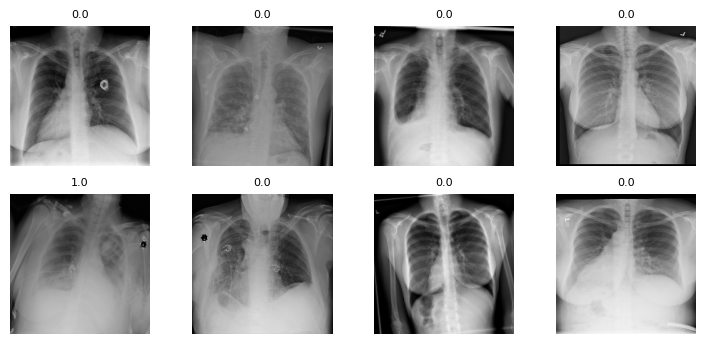

In [22]:
fig, axes = plt.subplots(2,4, figsize=(9, 4), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=8)
    ax.axis('off')

- ## Building Model:

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [24]:
def Pneumonia_Model(input_shape):

  basemodel=ResNet50(include_top=False,input_shape=input_shape)


  flat=layers.Flatten()(basemodel.output)

  Dense1=layers.Dense(128,activation='relu',kernel_regularizer=l2(0.1))(flat)
  drop3=layers.Dropout(.2)(Dense1)
  Dense2=layers.Dense(64,activation='relu',kernel_regularizer=l2(0.1))(drop3)
  drop3=layers.Dropout(.2)(Dense2)
  output=layers.Dense(1,activation='sigmoid')(drop3)

  model=Model(basemodel.input,output)

  return model

In [25]:
model=Pneumonia_Model((224,224,3))

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [27]:
plot_model(model,show_shapes=True,expand_nested=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
#from tensorflow.keras.metrics import F1Score
#from tensorflow.keras.losses import BinaryFocalCrossentropy
model.compile(optimizer=Adam(1e-4),loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau

checkpoint = ModelCheckpoint('RSNA_Pneumonia.h5',
                                            monitor="val_loss",
                                            verbose=1,
                                            save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=3,
                            min_lr=1e-8,
                            verbose=1
                        )


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

In [30]:
history=model.fit(train_gen,
          epochs=40,
          steps_per_epoch=len(train_gen),
          validation_data=val_gen,
          validation_steps=len(val_gen),
          class_weight=class_weight_dict,
          callbacks=[checkpoint,reduce_lr,early_stopping])


Epoch 1/40
2702/2702 [==============================] - ETA: 0s - loss: 5.0810 - accuracy: 0.7287
Epoch 1: val_loss improved from inf to 1.11388, saving model to RSNA_Pneumonia.h5
2702/2702 [==============================] - 473s 170ms/step - loss: 5.0810 - accuracy: 0.7287 - val_loss: 1.1139 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 2/40
2702/2702 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7647
Epoch 2: val_loss improved from 1.11388 to 0.49678, saving model to RSNA_Pneumonia.h5
2702/2702 [==============================] - 459s 170ms/step - loss: 0.7372 - accuracy: 0.7647 - val_loss: 0.4968 - val_accuracy: 0.8372 - lr: 1.0000e-04
Epoch 3/40
2702/2702 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.7687
Epoch 3: val_loss improved from 0.49678 to 0.48075, saving model to RSNA_Pneumonia.h5
2702/2702 [==============================] - 465s 172ms/step - loss: 0.5341 - accuracy: 0.7687 - val_loss: 0.4808 - val_accuracy: 0.7839 - lr: 1

In [32]:
model.evaluate(test_gen,steps=len(test_gen))

334/334 [==============================] - 47s 140ms/step - loss: 0.4454 - accuracy: 0.7943


[0.44541487097740173, 0.7943049669265747]

In [34]:
model.save('Pneumonia_Model.h5')